<a href="https://colab.research.google.com/github/achelousace/Prediction-of-Product/blob/main/Prediction_of_Product_Sales_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Prediction of Product Sales**


- Author: Mohammad Abu Ayyash

## Project Overview

## Load and Inspect Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/StudentFolders16wk24wk/CodingDojo/01-Fundamentals/Week02/Data/sales_predictions_2023.csv")

In [ ]:
import missingno as msno

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [ ]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


## Clean Data

In [ ]:
df.shape

(8523, 12)

##### 12 columns , 8523 rows

In [ ]:
df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

##### data type : object = 7 , numeric  = 5

In [ ]:
dup = df.duplicated(keep=False)
dup.sum()

0

No dublicates

In [ ]:
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

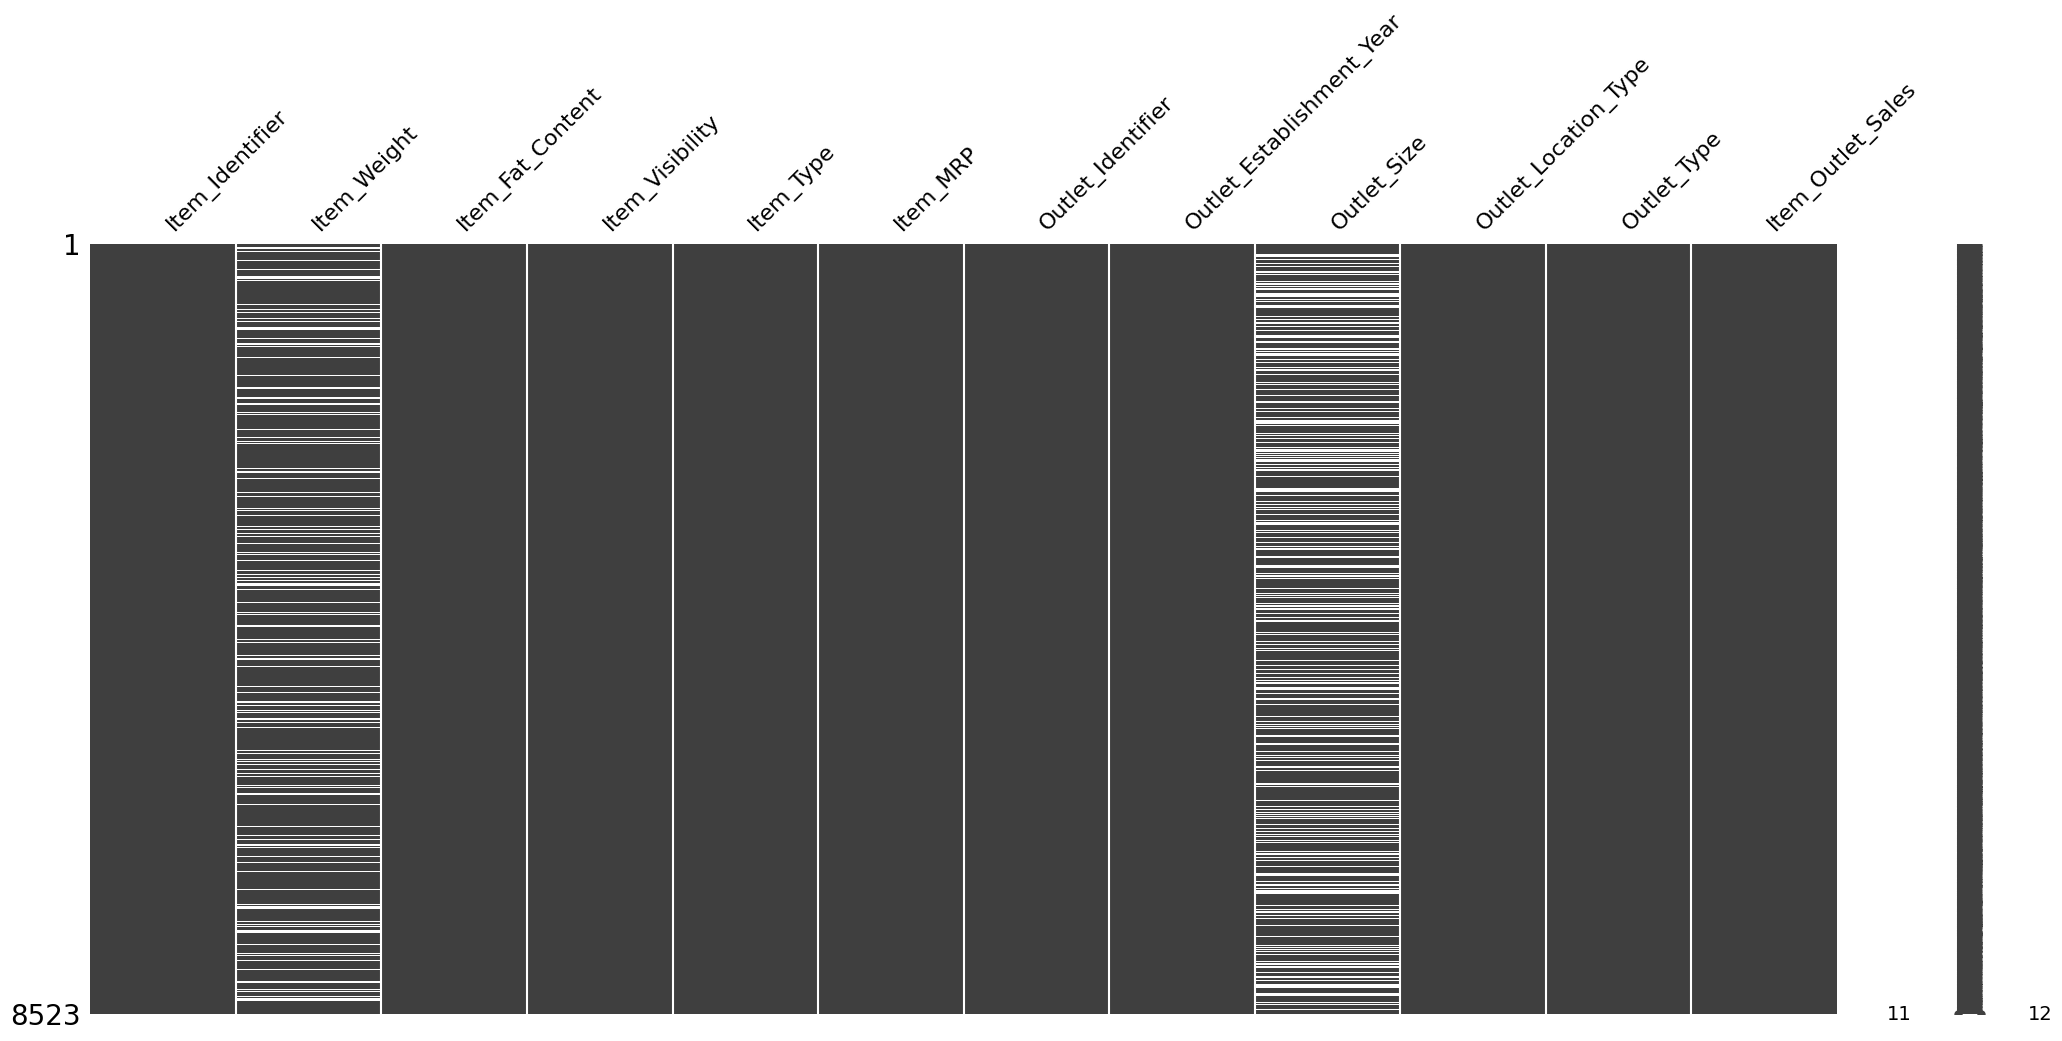

In [ ]:
msno.matrix(df);

(Item weight, outlet size) have a missing values

In [ ]:
#df['Outlet_Size'] = df['Outlet_Size'].fillna('MISSING')

In [ ]:
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

##### Now (Item Size) null's is filled with a placeholder ("Missing")

In [ ]:
#df['Item_Weight'] = df['Item_Weight'].fillna(-1)

In [ ]:
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

##### Now (Item Weight) have also a placeholder (-1) , which makes no-nulls in the dataframe.

In [ ]:
objects = df.select_dtypes('object').columns
objects

Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')

In [ ]:
for col in objects:
    print (f'value_count{col}')
    print (df[col].value_counts())
    print('\n')

value_countItem_Identifier
Item_Identifier
FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: count, Length: 1559, dtype: int64


value_countItem_Fat_Content
Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: count, dtype: int64


value_countItem_Type
Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: count, dtype: int64


value_countOutlet_Identifier
Outlet_Identifier
OUT027    935
OUT013    932
OUT049    930
OU

##### identified (Item_Fat_Content) as a feature that have a inconsistent data values

In [ ]:
df ['Item_Fat_Content'] = df['Item_Fat_Content'].replace({'LF':'Low Fat','low fat':'Low Fat','reg':'Regular'})

In [ ]:
df['Item_Fat_Content'].value_counts()

Item_Fat_Content
Low Fat    5517
Regular    3006
Name: count, dtype: int64

##### dealt with all inconsistent data values in the dataframe

In [ ]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


#####This is summary statistics of each numerical feature (columns) in the dataframe

In [ ]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


#### This is the dataframe summery after cleaning.

## Exploratory Data Analysis

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [ ]:
numbercols = df.select_dtypes('number').columns

In [ ]:
num = numbercols.value_counts(normalize=True)
num

Item_Weight                  0.2
Item_Visibility              0.2
Item_MRP                     0.2
Outlet_Establishment_Year    0.2
Item_Outlet_Sales            0.2
Name: proportion, dtype: float64

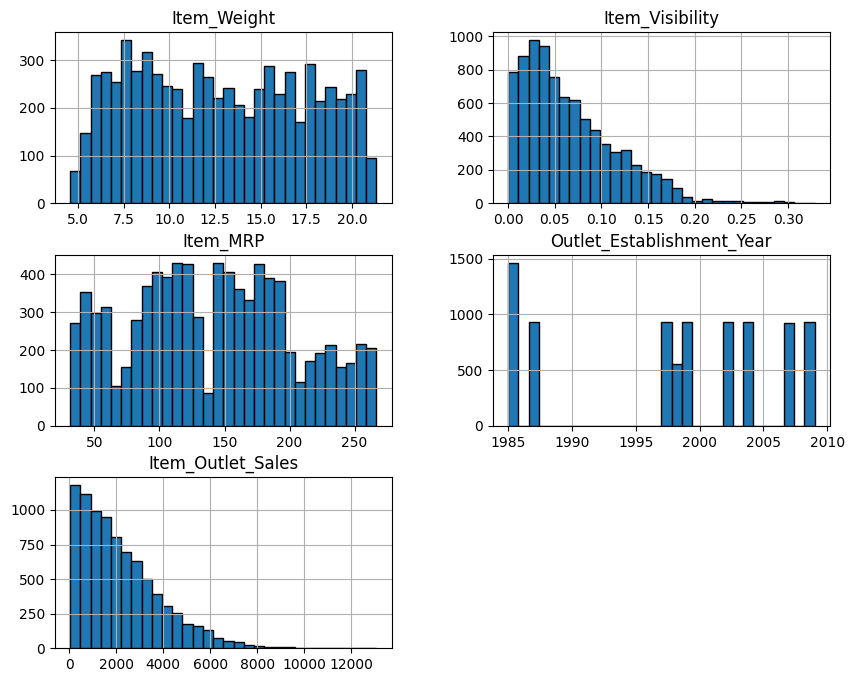

In [ ]:
ax = df[numbercols].hist(bins=30,edgecolor='black', figsize=(10,8))

##### This is the general distribution of data in the numerical columns of this dataframe

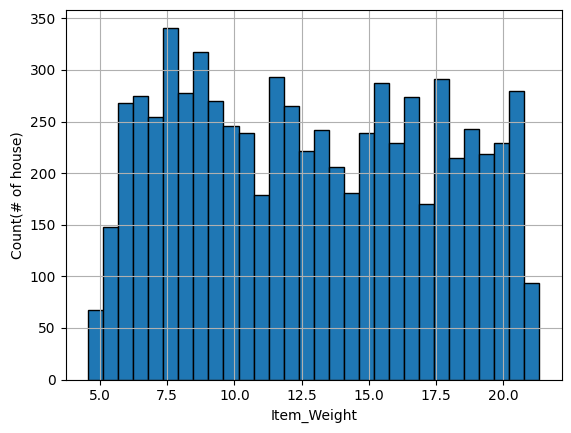

In [ ]:
ax = df['Item_Weight'].hist(bins=30,edgecolor='black')
ax.set_ylabel('Count(# of house)');
ax.set_xlabel('Item_Weight');

##### after plotting 'item weight' feature it indicates a missing values as shown visually

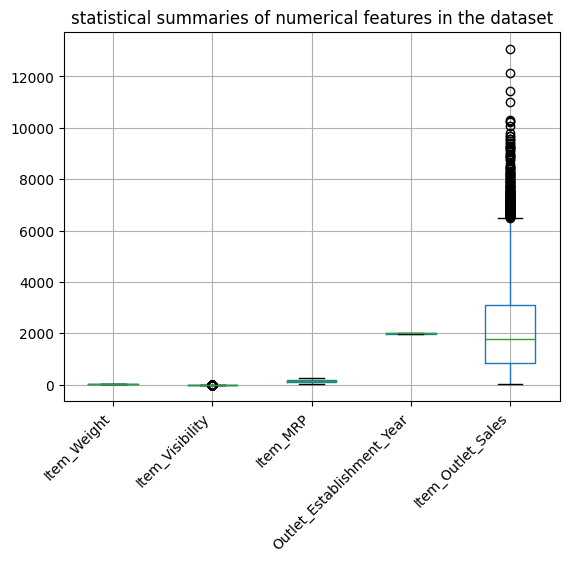

In [ ]:
ax = df.boxplot()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right');
ax.set_title('statistical summaries of numerical features in the dataset');

##### a statistical summaries of numerical features in the dataset as a boxplot

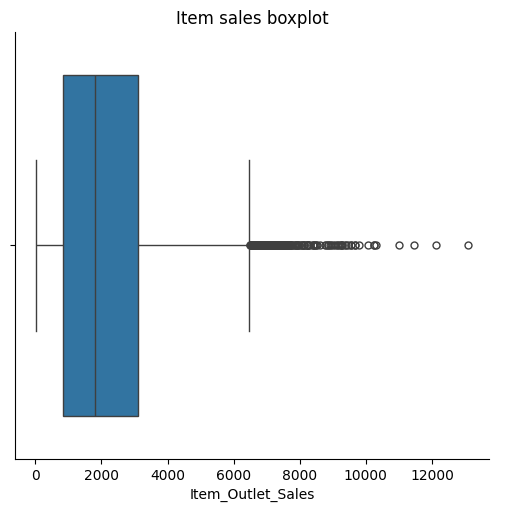

In [ ]:
boxplot = sns.catplot(data=df, x='Item_Outlet_Sales',kind='box', dodge=False)
boxplot.ax.set_title('Item sales boxplot');

##### a closer inspection of 'item sales' distribution

In [ ]:
black = dict(color='black')
scatters = dict(edgecolor='white')

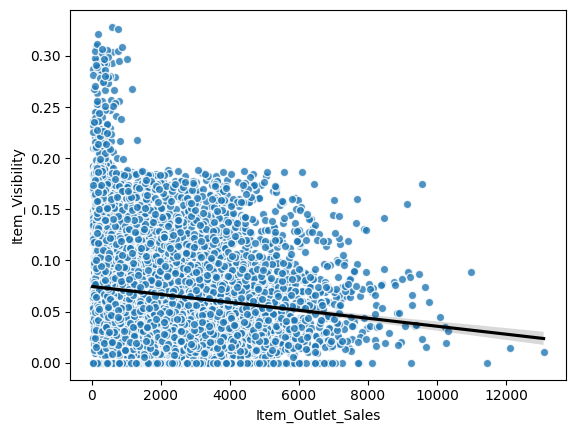

In [ ]:
sns.regplot(data=df,x='Item_Outlet_Sales',y='Item_Visibility',line_kws=black, scatter_kws=scatters);

##### this regplot explains the correlation between item visibility and item oulet sales

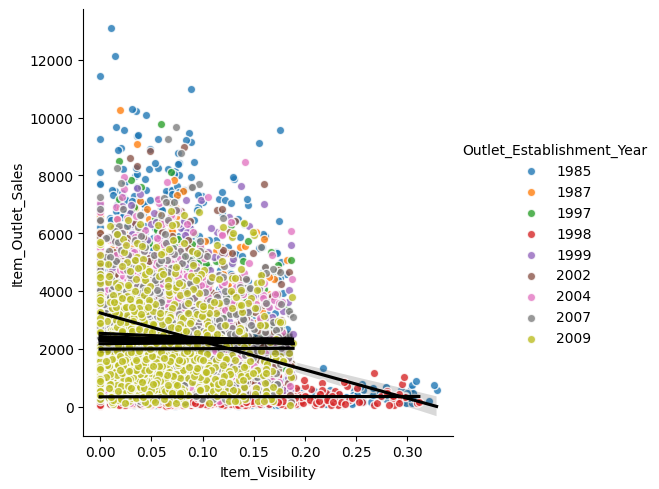

In [ ]:
ax = sns.lmplot(data=df,y='Item_Outlet_Sales',x='Item_Visibility',line_kws=black, scatter_kws=scatters, hue='Outlet_Establishment_Year');

##### a scatter plot explaining the different relationship between the item visibility and establishment year and the influance on sales

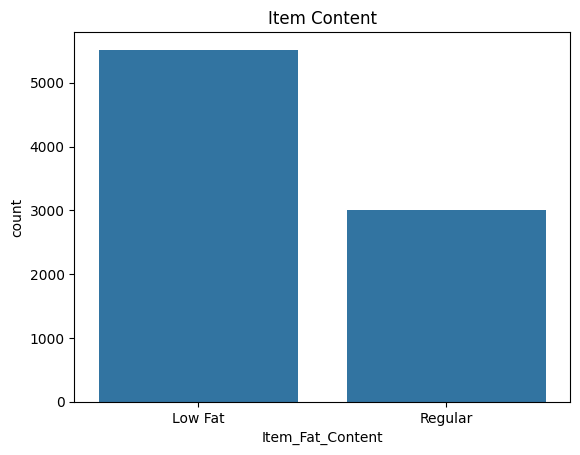

In [ ]:
ax = sns.countplot(data=df,x='Item_Fat_Content')
ax.set_title('Item Content');

##### item content values count

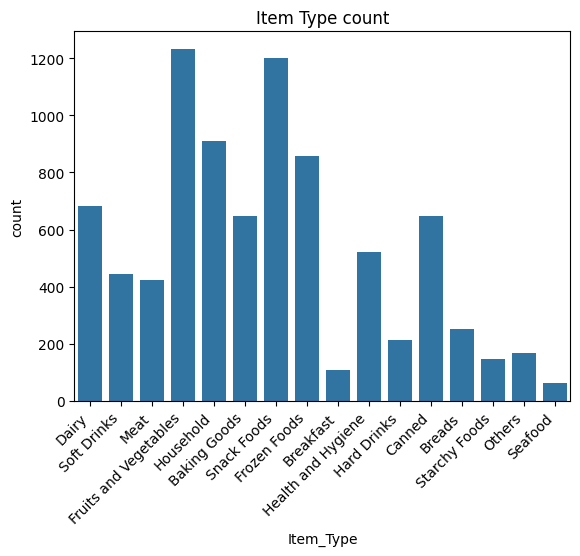

In [ ]:
ax = sns.countplot(data=df,x='Item_Type');
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right');
ax.set_title('Item Type count');

##### item type counts in the 'item type' feature

In [ ]:
val_counts = df['Outlet_Size'].value_counts()
val_counts.index

Index(['Medium', 'Small', 'High'], dtype='object', name='Outlet_Size')

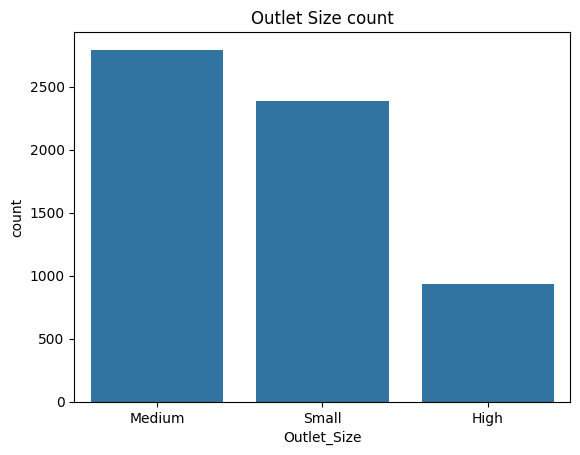

In [ ]:
ax = sns.countplot(data=df,x='Outlet_Size',order=val_counts.index);
ax.set_title('Outlet Size count');

##### the value count of "Outlet_Size" by order of the index feature

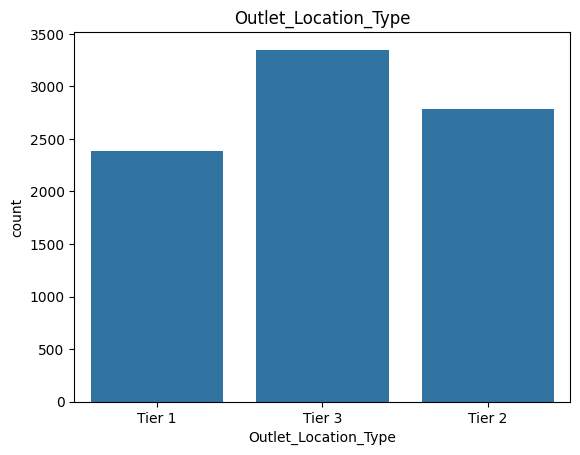

In [ ]:
ax = sns.countplot(data=df,x='Outlet_Location_Type')
ax.set_title('Outlet_Location_Type');

##### the location plot of outlet

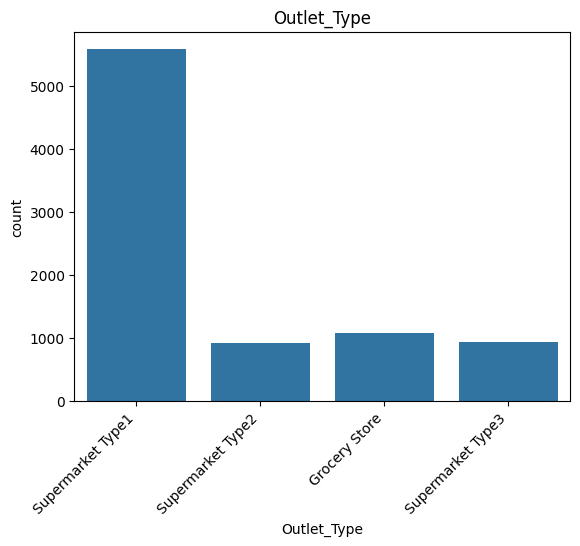

In [ ]:
ax = sns.countplot(data=df,x='Outlet_Type')
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right');
ax.set_title('Outlet_Type');

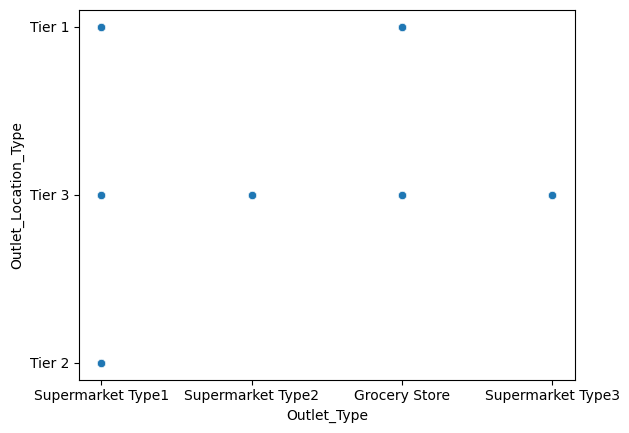

In [ ]:
sns.scatterplot(data=df, x='Outlet_Type', y='Outlet_Location_Type');


##### the relationship between outlet type and location

In [ ]:
cor = df.corr(numeric_only=True)
cor.round(2)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
Item_Weight,1.00,-0.01,0.03,-0.01,0.01
Item_Visibility,-0.01,1.00,-0.00,-0.07,-0.13
Item_MRP,0.03,-0.00,1.00,0.01,0.57
Outlet_Establishment_Year,-0.01,-0.07,0.01,1.00,-0.05
Item_Outlet_Sales,0.01,-0.13,0.57,-0.05,1.00


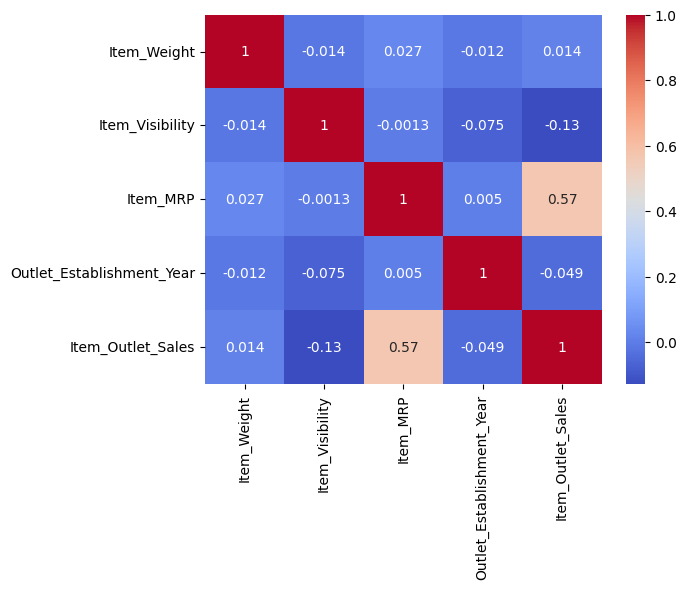

In [ ]:
sns.heatmap(cor,cmap='coolwarm',annot=True);

##### a heat map to show the different relations between numerical features positively or negatively as shown

## Feature Inspection

### **Data Inspection**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


### **Inspecting: Item_Weight**

#### 1) Data Dictionary

* 	Weight of product


#### 2) Univariate Viz

##### Confirming the dtype to select correct EDA function

In [ ]:
feature_1 = "Item_Weight"

In [ ]:
df[feature_1].dtype

dtype('float64')

##### Calling our custom EDA function

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
def explore_numeric(df, x, figsize=(6,5) ):
  gridspec = {'height_ratios':[0.7,0.3]}
  fig, axes = plt.subplots(nrows=2, figsize=figsize,sharex=True, gridspec_kw=gridspec)
  sns.histplot(data=df, x=x, ax=axes[0])
  sns.boxplot(data=df, x=x, ax=axes[1])
  axes[0].set_title(f"Column: {x}")
  fig.tight_layout()
  plt.show()
  null_count = df[x].isna().sum()
  null_perc = null_count/len(df)* 100
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")

##### ploting for inspection

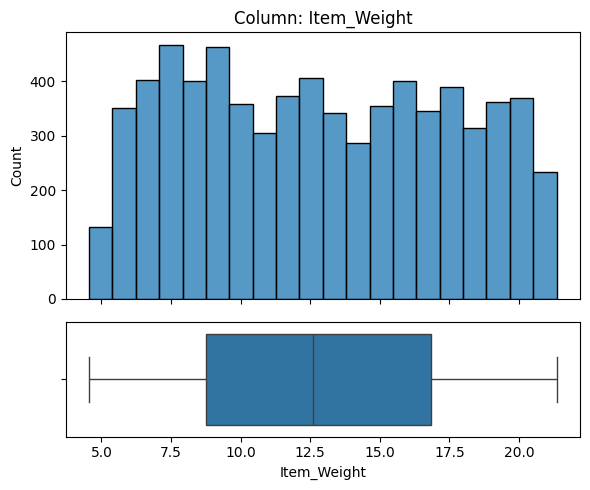

- NaN's Found: 1463 (17.17%)


In [ ]:
explore_numeric(df,feature_1)

* its a numerical feature.
* there are 1463 null values which is 17.17% of the feature.
* we should inspect the column for missing values if they are randomly missing or not In order to know how to handle them.
* this feature is not constant or quasi-constant.
* cardinality Not applicable (numeric feature).
* we would know this feature before the target is determined.
* The feature may be beyond the owner's control and it wouldn't be helpful in predicting sale price.

#### 3) Multivariate Viz

##### Calling our custom EDA function

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_numeric_vs_target(df, x, y='Item_Outlet_Sales', figsize=(6,4), **kwargs):
  corr = df[[x,y]].corr().round(2)
  r = corr.loc[x,y]
  fig, ax = plt.subplots(figsize=figsize)
  scatter_kws={'ec':'white','linewidths':1,'alpha':0.8}
  sns.regplot(data=df, x=x, y=y, ax=ax, scatter_kws=scatter_kws, **kwargs)
  ax.set_title(f"{x} vs. {y} (r = {r})")
  plt.show()
  return fig, ax

##### ploting for inspection

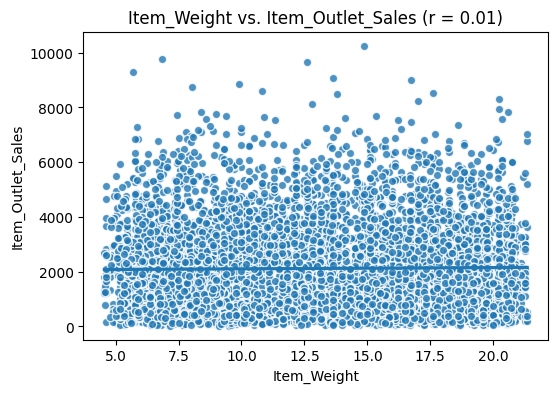

In [ ]:
plot_numeric_vs_target(df,feature_1);

* I wouldn't expect the item weight to impact the sale price.
* this feature dosn't appear to be a predictor of the target since its not releated to the sale price trendline.

### **Inspecting: Item_Fat_Content**

#### 1) Data Dictionary

* regular
* low-fat

#### 2) Univariate Viz

##### Confirming the dtype to select correct EDA function

In [ ]:
feature_2 = 'Item_Fat_Content'

In [ ]:
df[feature_2].dtype

dtype('O')

##### Calling our custom EDA function

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def explore_categorical(df, x, fillna = True, placeholder = 'MISSING', figsize = (6,4), order = None):
  temp_df = df.copy()
  null_count = temp_df[x].isna().sum()
  null_perc = null_count/len(temp_df)* 100
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  fig, ax = plt.subplots(figsize=figsize)
  sns.countplot(data=temp_df, x=x, ax=ax, order=order)
  ax.set_xticks(ax.get_xticks())
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  ax.set_title(f"Column: {x}")
  fig.tight_layout()
  plt.show()
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  nunique = temp_df[x].nunique()
  print(f"- Unique Values: {nunique}")
  val_counts = temp_df[x].value_counts(dropna=False)
  most_common_val = val_counts.index[0]
  freq = val_counts.values[0]
  perc_most_common = freq / len(temp_df) * 100
  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, ax

##### ploting for inspection

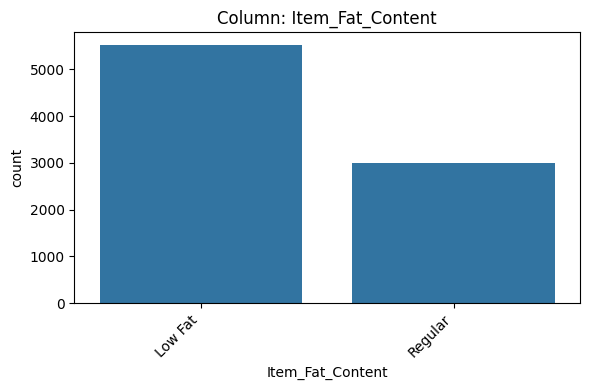

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: 'Low Fat' occurs 5517 times (64.73%)
- Not constant or quasi-constant.


In [ ]:
explore_categorical(df,feature_2);

* its a categorical feature.
* there are non-null values.
* its not constant or quasi-constant.
* cardinality is low.
* we would know this feature before the target is determined.
* there no need to exclude this feature beacuse it might be releated (negative or positive) to the sale price.

####3) Multivariate Viz

##### Calling our custom EDA function

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_categorical_vs_target(df, x, y='Item_Outlet_Sales',figsize=(6,4),fillna = True, placeholder = 'MISSING',order = None):
  temp_df = df.copy()
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  else:
    temp_df = temp_df.dropna(subset=[x])
  fig, ax = plt.subplots(figsize=figsize)
  sns.barplot(data=temp_df, x=x, y=y, ax=ax, order=order, alpha=0.6,linewidth=1, edgecolor='black', errorbar=None)
  sns.stripplot(data=temp_df, x=x, y=y, hue=x, ax=ax, order=order, hue_order=order, legend=False,edgecolor='white', linewidth=0.5,size=3,zorder=0)
  ax.set_xticks(ax.get_xticks())
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  ax.set_title(f"{x} vs. {y}")
  fig.tight_layout()
  return fig, ax

##### ploting for inspection

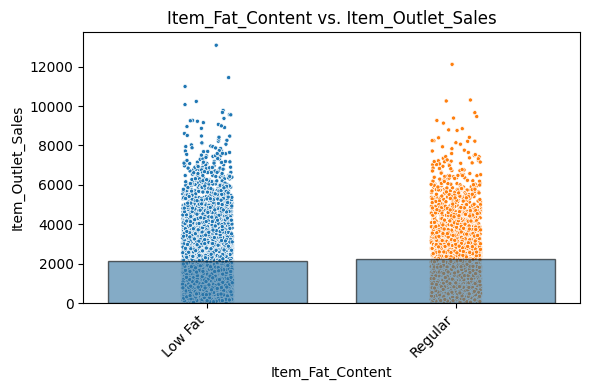

In [ ]:
plot_categorical_vs_target(df,feature_2);

* I wouldn't expect the item fat content to impact the sale price due to the close value of regular and low fat items consumption.

* the range of values for item fat content is similar in range of the other categorie so it dosent appear to be a predictor of sale price.

### **Inspecting: Item_Visibility**

#### 1) Data Dictionary

* Percentage of total display area of all products in a store allocated to the particular product


#### 2) Univariate Viz

##### Confirming the dtype to select correct EDA function

In [ ]:
feature_3 = "Item_Visibility"

In [ ]:
df[feature_3].dtype

dtype('float64')

##### Calling our custom EDA function

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
def explore_numeric(df, x, figsize=(6,5) ):
  gridspec = {'height_ratios':[0.7,0.3]}
  fig, axes = plt.subplots(nrows=2, figsize=figsize,sharex=True, gridspec_kw=gridspec)
  sns.histplot(data=df, x=x, ax=axes[0])
  sns.boxplot(data=df, x=x, ax=axes[1])
  axes[0].set_title(f"Column: {x}")
  fig.tight_layout()
  plt.show()
  null_count = df[x].isna().sum()
  null_perc = null_count/len(df)* 100
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")

##### ploting for inspection

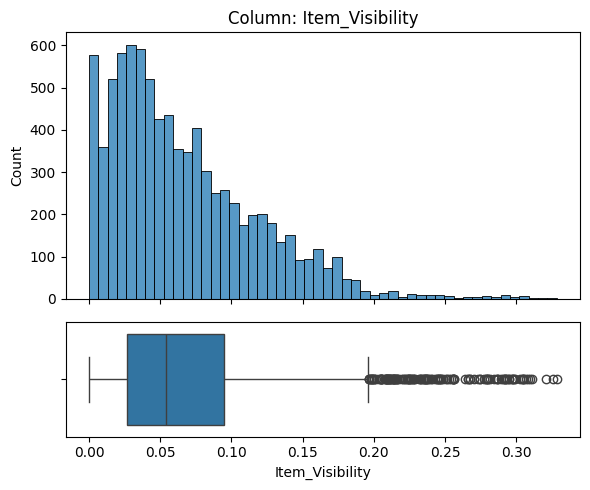

- NaN's Found: 0 (0.0%)


In [ ]:
explore_numeric(df,feature_3);

* its a numerical feature.
* there are no null values in this feature.
* this feature is not constant or quasi-constant.
* cardinality Not applicable (numeric feature).
* we would know this feature before the target is determined.
* This feature is not beyond the owner's control and it would be helpful to adjust the future outcomes for our sale price products.

#### 3) Multivariate Viz

##### Calling our custom EDA function

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_numeric_vs_target(df, x, y='Item_Outlet_Sales', figsize=(6,4), **kwargs):
  corr = df[[x,y]].corr().round(2)
  r = corr.loc[x,y]
  fig, ax = plt.subplots(figsize=figsize)
  scatter_kws={'ec':'white','linewidths':1,'alpha':0.8}
  sns.regplot(data=df, x=x, y=y, ax=ax, scatter_kws=scatter_kws, **kwargs)
  ax.set_title(f"{x} vs. {y} (r = {r})")
  plt.show()
  return fig, ax

##### ploting for inspection

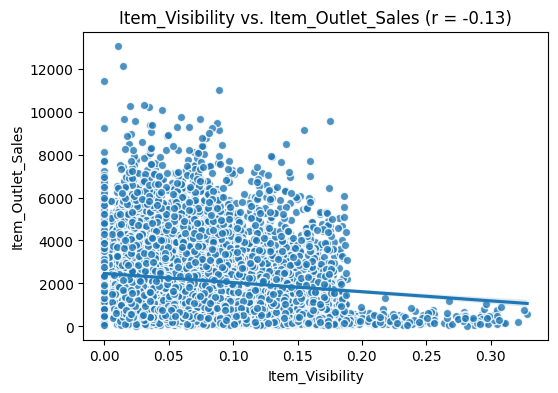

In [ ]:
plot_numeric_vs_target(df,feature_3);

* I would expect the item visibility to impact the sale price negativly since its on a negtive slop regration.
* this feature might appear to be a predictor of the target since its releated to the sale price trendline.

### **Inspecting: Item_Type**




#### 1) Data Dictionary

The category to which the product belongs

#### 2) Univariate Viz

##### Confirming the dtype to select correct EDA function

In [ ]:
feature_4 = 'Item_Type'

In [ ]:
df[feature_4].dtype

dtype('O')

##### Calling our custom EDA function

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def explore_categorical(df, x, fillna = True, placeholder = 'MISSING', figsize = (6,4), order = None):
  temp_df = df.copy()
  null_count = temp_df[x].isna().sum()
  null_perc = null_count/len(temp_df)* 100
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  fig, ax = plt.subplots(figsize=figsize)
  sns.countplot(data=temp_df, x=x, ax=ax, order=order)
  ax.set_xticks(ax.get_xticks())
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  ax.set_title(f"Column: {x}")
  fig.tight_layout()
  plt.show()
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  nunique = temp_df[x].nunique()
  print(f"- Unique Values: {nunique}")
  val_counts = temp_df[x].value_counts(dropna=False)
  most_common_val = val_counts.index[0]
  freq = val_counts.values[0]
  perc_most_common = freq / len(temp_df) * 100
  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, ax

##### ploting for inspection

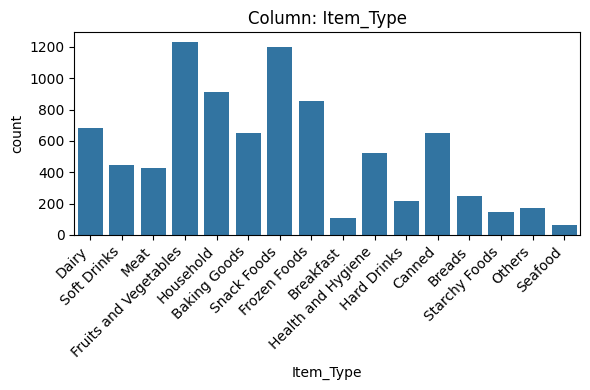

- NaN's Found: 0 (0.0%)
- Unique Values: 16
- Most common value: 'Fruits and Vegetables' occurs 1232 times (14.46%)
- Not constant or quasi-constant.


In [ ]:
explore_categorical(df,feature_4);

* its a categorical feature.
* there are non-null values.
* its not constant or quasi-constant.
* cardinality is High.
* we would know this feature before the target is determined.
* there no need to exclude this feature beacuse it is essential to the sale price.

####3) Multivariate Viz

##### Calling our custom EDA function

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_categorical_vs_target(df, x, y='Item_Outlet_Sales',figsize=(6,4),fillna = True, placeholder = 'MISSING',order = None):
  temp_df = df.copy()
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  else:
    temp_df = temp_df.dropna(subset=[x])
  fig, ax = plt.subplots(figsize=figsize)
  sns.barplot(data=temp_df, x=x, y=y, ax=ax, order=order, alpha=0.6,linewidth=1, edgecolor='black', errorbar=None)
  sns.stripplot(data=temp_df, x=x, y=y, hue=x, ax=ax, order=order, hue_order=order, legend=False,edgecolor='white', linewidth=0.5,size=3,zorder=0)
  ax.set_xticks(ax.get_xticks())
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  ax.set_title(f"{x} vs. {y}")
  fig.tight_layout()
  return fig, ax

##### ploting for inspection

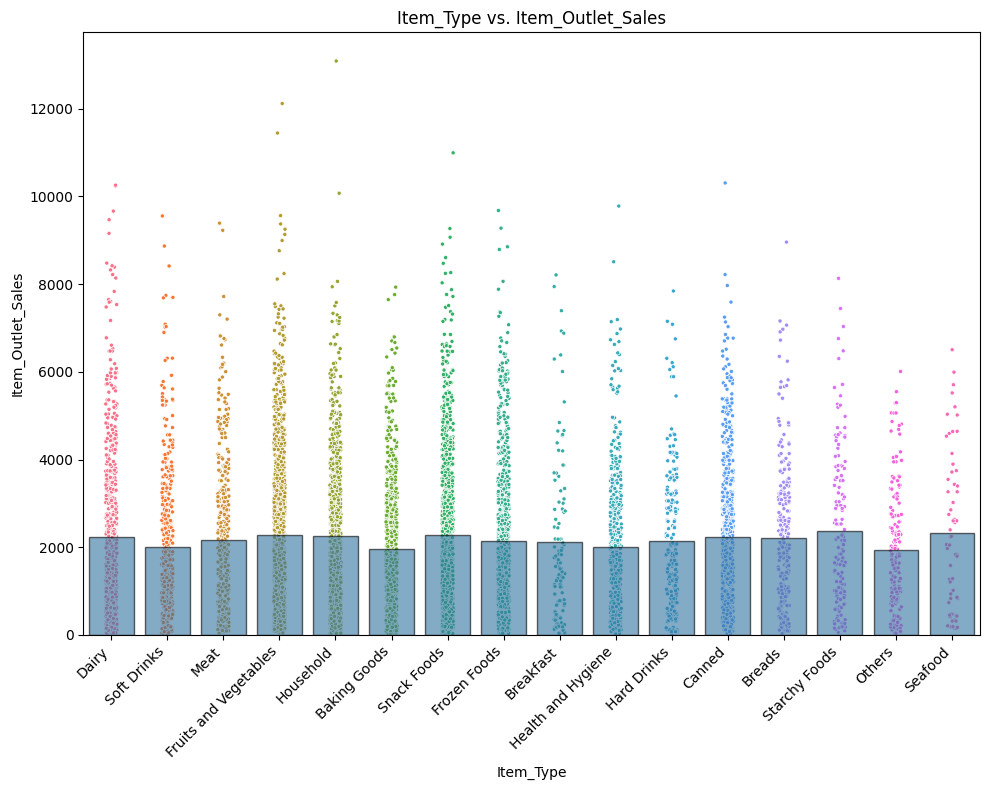

In [ ]:
plot_categorical_vs_target(df,feature_4,figsize=(10,8));

* I would expect the Item type content to impact the sale price due to the high values consumption of different content items such as snack foods, fruits and vegetabels.

* the range of values for item type content appears to be a direct predictor of sale prices.

### **Inspecting: Item_MRP**

#### 1) Data Dictionary

* Maximum Retail Price (list price) of the product

#### 2) Univariate Viz

##### Confirming the dtype to select correct EDA function

In [ ]:
feature_5 = "Item_MRP"

In [ ]:
df[feature_5].dtype

dtype('float64')

##### Calling our custom EDA function

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
def explore_numeric(df, x, figsize=(6,5) ):
  gridspec = {'height_ratios':[0.7,0.3]}
  fig, axes = plt.subplots(nrows=2, figsize=figsize,sharex=True, gridspec_kw=gridspec)
  sns.histplot(data=df, x=x, ax=axes[0])
  sns.boxplot(data=df, x=x, ax=axes[1])
  axes[0].set_title(f"Column: {x}")
  fig.tight_layout()
  plt.show()
  null_count = df[x].isna().sum()
  null_perc = null_count/len(df)* 100
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")

##### ploting for inspection

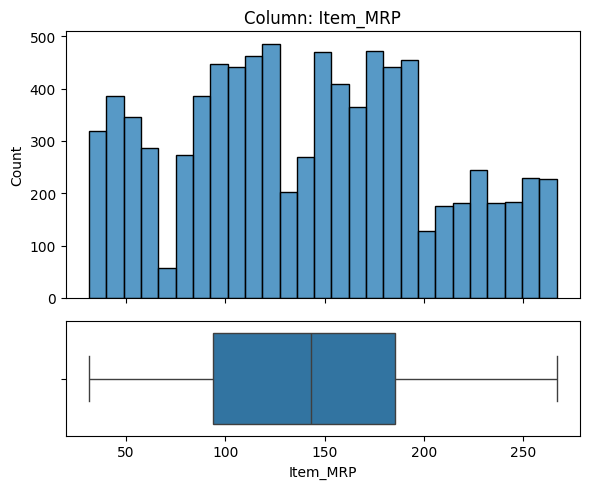

- NaN's Found: 0 (0.0%)


In [ ]:
explore_numeric(df,feature_5);

* its a numerical feature.
* there are no null values in this feature.
* this feature is not constant or quasi-constant.
* cardinality Not applicable (numeric feature).
* we would know this feature before the target is determined.
* The feature is in the owner's control and it wouldnt be very helpful in predicting sale prices.

#### 3) Multivariate Viz

##### Calling our custom EDA function

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_numeric_vs_target(df, x, y='Item_Outlet_Sales', figsize=(6,4), **kwargs):
  corr = df[[x,y]].corr().round(2)
  r = corr.loc[x,y]
  fig, ax = plt.subplots(figsize=figsize)
  scatter_kws={'ec':'white','linewidths':1,'alpha':0.8}
  sns.regplot(data=df, x=x, y=y, ax=ax, scatter_kws=scatter_kws, **kwargs)
  ax.set_title(f"{x} vs. {y} (r = {r})")
  plt.show()
  return fig, ax

##### ploting for inspection

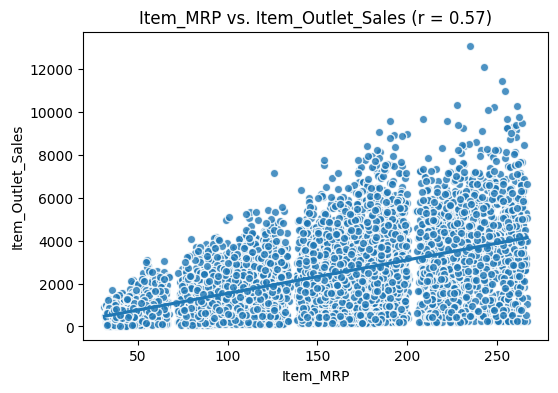

In [ ]:
plot_numeric_vs_target(df,feature_5);

* I would expect the item max retail price to impact the sale price since its one of the sale price factors.
* this feature appear to be a predictor of the target since its part of the sale price with a possitive trendline.

# ML

## Load Data

In [ ]:
pd.set_option('display.max_columns',100)
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn import set_config
set_config(transform_output='pandas')

In [ ]:
af = pd.read_csv('/content/drive/MyDrive/StudentFolders16wk24wk/CodingDojo/02-IntroML/Week05/Data/sales_predictions_2023.csv')

## Inspect Data

In [ ]:
af.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [ ]:
af.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


## Clean Data

In [ ]:
af.duplicated().sum()

0

In [ ]:
objecto = af.select_dtypes('object').columns
objecto

Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')

In [ ]:
for col in objecto:
    print (f'value_count{col}')
    print (df[col].value_counts())
    print('\n')

value_countItem_Identifier
Item_Identifier
FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: count, Length: 1559, dtype: int64


value_countItem_Fat_Content
Item_Fat_Content
Low Fat    5517
Regular    3006
Name: count, dtype: int64


value_countItem_Type
Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: count, dtype: int64


value_countOutlet_Identifier
Outlet_Identifier
OUT027    935
OUT013    932
OUT049    930
OUT046    930
OUT035    930
OUT045    929
OUT018  

In [ ]:
af ['Item_Fat_Content'] = af['Item_Fat_Content'].replace({'LF':'Low Fat','low fat':'Low Fat','reg':'Regular'})

In [ ]:
af['Item_Fat_Content'].value_counts()

Item_Fat_Content
Low Fat    5517
Regular    3006
Name: count, dtype: int64

In [ ]:
af = af.drop(columns=['Item_Identifier'])

## ML Column Transfer

#### inspect data

In [ ]:
af.value_counts()

Item_Weight  Item_Fat_Content  Item_Visibility  Item_Type              Item_MRP  Outlet_Identifier  Outlet_Establishment_Year  Outlet_Size  Outlet_Location_Type  Outlet_Type        Item_Outlet_Sales
4.555        Regular           0.034329         Frozen Foods           110.1544  OUT013             1987                       High         Tier 3                Supermarket Type1  1230.3984            1
15.700       Regular           0.027730         Canned                 169.3790  OUT018             2009                       Medium       Tier 3                Supermarket Type2  1528.0110            1
             Low Fat           0.045166         Frozen Foods           178.6660  OUT013             1987                       High         Tier 3                Supermarket Type1  2516.7240            1
                               0.037384         Soft Drinks            179.7634  OUT018             2009                       Medium       Tier 3                Supermarket Type2  1817.634

In [ ]:
af.isna().sum()

Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [ ]:
af.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


#### Split Data

In [ ]:
X = af.drop(columns = 'Item_Outlet_Sales')
y = af['Item_Outlet_Sales']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

#### numeric columns

In [ ]:
num_cols = X_train.select_dtypes("number").columns
print("Numeric Columns:", num_cols)

Numeric Columns: Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')


In [ ]:
impute_median = SimpleImputer(strategy='median')

In [ ]:
scaler = StandardScaler()

In [ ]:
num_pipe = make_pipeline(impute_median, scaler)
num_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [ ]:
num_tuple = ('numeric', num_pipe, num_cols)
num_tuple

('numeric',
 Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                 ('standardscaler', StandardScaler())]),
 Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
        'Outlet_Establishment_Year'],
       dtype='object'))

#### ordinal columns

In [ ]:
af['Outlet_Size'].value_counts()

Outlet_Size
Medium    2793
Small     2388
High       932
Name: count, dtype: int64

In [ ]:
ord_cols = ['Outlet_Size']
print("Ordinal Columns:", ord_cols)

Ordinal Columns: ['Outlet_Size']


In [ ]:
qual_cond_order = ['Small','Medium', 'High']

In [ ]:
ordinal_category_orders = [qual_cond_order]

In [ ]:
impute_na_ord = SimpleImputer(strategy='most_frequent', fill_value='NA')

In [ ]:
ord_encoder = OrdinalEncoder(categories=ordinal_category_orders)

In [ ]:
scaler_ord = StandardScaler()

In [ ]:
ord_pipe = make_pipeline(impute_na_ord, ord_encoder, scaler_ord)
ord_pipe

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='NA', strategy='most_frequent')),
                ('ordinalencoder',
                 OrdinalEncoder(categories=[['Small', 'Medium', 'High']])),
                ('standardscaler', StandardScaler())])

In [ ]:
ord_tuple = ('ordinal', ord_pipe, ord_cols)
ord_tuple

('ordinal',
 Pipeline(steps=[('simpleimputer',
                  SimpleImputer(fill_value='NA', strategy='most_frequent')),
                 ('ordinalencoder',
                  OrdinalEncoder(categories=[['Small', 'Medium', 'High']])),
                 ('standardscaler', StandardScaler())]),
 ['Outlet_Size'])

#### categorical columns

In [ ]:
ohe_cols = X_train.select_dtypes('object').drop(columns=ord_cols).columns
print("OneHotEncoder Columns:", ohe_cols)

OneHotEncoder Columns: Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')


In [ ]:
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

In [ ]:
ohe_pipe = make_pipeline(ohe_encoder)
ohe_pipe

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

In [ ]:
ohe_tuple = ('categorical', ohe_pipe, ohe_cols)
ohe_tuple

('categorical',
 Pipeline(steps=[('onehotencoder',
                  OneHotEncoder(handle_unknown='ignore', sparse_output=False))]),
 Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
        'Outlet_Location_Type', 'Outlet_Type'],
       dtype='object'))

#### columns transfer

In [ ]:
col_transformer = ColumnTransformer([num_tuple, ord_tuple, ohe_tuple],verbose_feature_names_out=False)

In [ ]:
col_transformer.fit(X_train)

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                ('ordinal',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='most_frequent')),
                                                 ('ord...
                                                  OrdinalEncoder(categories=[['Small',
                                                                              'Medium',
                                                                              'High']])),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Outlet_Size']),
                                ('categorical',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object'))],
                  verbose_feature_names_out=False)

In [ ]:
X_train_processed = col_transformer.transform(X_train)

In [ ]:
X_test_processed = col_transformer.transform(X_test)

#### columns transfer inspection

In [ ]:
X_train_processed.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
4776,0.827485,-0.712775,1.828109,1.327849,0.287374,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
7510,0.566644,-1.291052,0.603369,1.327849,0.287374,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5828,-0.121028,1.813319,0.244541,0.136187,0.287374,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
5327,-1.158464,-1.004931,-0.952591,0.732018,-1.384048,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4810,1.538870,-0.965484,-0.336460,0.493686,0.287374,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
X_test_processed.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
7503,0.341372,-0.776646,-0.998816,-1.293807,1.958796,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2957,-1.169135,0.100317,-1.585194,-0.102145,-1.384048,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
7031,0.388798,-0.482994,-1.595784,0.136187,0.287374,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1084,-0.049889,-0.415440,0.506592,-1.532139,0.287374,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
856,-0.632039,-1.047426,0.886725,0.732018,-1.384048,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


# ML Modeling

## Imports

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor

In [ ]:
def regression_metrics(y_true, y_pred, label='', verbose = True, output_dict=False):
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = mean_squared_error(y_true, y_pred, squared=False)
  r_squared = r2_score(y_true, y_pred)
  if verbose == True:
    header = "-"*60
    print(header, f"Regression Metrics: {label}", header, sep='\n')
    print(f"- MAE = {mae:,.3f}")
    print(f"- MSE = {mse:,.3f}")
    print(f"- RMSE = {rmse:,.3f}")
    print(f"- R^2 = {r_squared:,.3f}")
  if output_dict == True:
      metrics = {'Label':label, 'MAE':mae,'MSE':mse, 'RMSE':rmse, 'R^2':r_squared}
      return metrics
def evaluate_regression(reg, X_train, y_train, X_test, y_test, verbose = True,output_frame=False):
  y_train_pred = reg.predict(X_train)
  results_train = regression_metrics(y_train, y_train_pred, verbose = verbose,output_dict=output_frame,label='Training Data')
  print()
  y_test_pred = reg.predict(X_test)
  results_test = regression_metrics(y_test, y_test_pred, verbose = verbose,output_dict=output_frame,label='Test Data' )
  if output_frame:
    results_df = pd.DataFrame([results_train,results_test])
    results_df = results_df.set_index('Label')
    results_df.index.name=None
    return results_df.round(3)

## Linear Regression Model

In [ ]:
linreg = LinearRegression()

In [ ]:
linreg_pipe = make_pipeline(col_transformer, linreg)

In [ ]:
linreg_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                                 ('ordinal',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value=...
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Outlet_Size']),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('linearregression', LinearRegression())])

In [ ]:
linreg_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                                 ('ordinal',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value=...
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Outlet_Size']),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('linearregression', LinearRegression())])

In [ ]:
evaluate_regression(linreg_pipe, X_train, y_train, X_test, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 847.131
- MSE = 1,297,556.865
- RMSE = 1,139.104
- R^2 = 0.562

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 804.089
- MSE = 1,194,326.602
- RMSE = 1,092.853
- R^2 = 0.567


* as we notice the out come of this Linear regression model with the training data and the test data is **Underfitting** since the R^2 values on both is 56.7%

## Random Forest Model

In [ ]:
rf = RandomForestRegressor(random_state = 42)

In [ ]:
rf_pipe = make_pipeline(col_transformer, rf)

In [ ]:
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                                 ('ordinal',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value=...
                                                                   StandardScaler())]),
                                                  ['Outlet_Size']),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [ ]:
evaluate_regression(rf_pipe, X_train, y_train, X_test, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 296.124
- MSE = 182,241.944
- RMSE = 426.898
- R^2 = 0.938

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 765.671
- MSE = 1,213,934.180
- RMSE = 1,101.787
- R^2 = 0.560


* as we notice the out come of this Random Forest model with the training data and the test data is **Overfitting** since the R^2 values on the training is 93.8% and 56% on the test data.
* in comparison with the linear regression model we may expect a better results in preformance to our goals if we modify this random forest model.

## Random Forest GridSearchCV

In [ ]:
rf_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('numeric',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
          'Outlet_Establishment_Year'],
         dtype='object')),
                                   ('ordinal',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(fill_value='NA',
                                                                   strategy='most_frequent')),
                                                    ('ord...
                                                     OrdinalEncoder(categories=[['Small

In [ ]:
params = {'randomforestregressor__max_depth': [None,10,15,20],
          'randomforestregressor__n_estimators':[10,100,150,200],
          'randomforestregressor__min_samples_leaf':[2,3,4],
          'randomforestregressor__max_features':['sqrt','log2',None],
          'randomforestregressor__oob_score':[True,False],
          }

In [ ]:
gridsearch = GridSearchCV(rf_pipe, params, n_jobs=-1, cv = 3, verbose=1)

In [ ]:
gridsearch.fit(X_train, y_train)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                                                        ('ordinal',
                                                                         Pipeline(steps=[('simpleimpute...
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__max_depth': [None, 10, 15, 20],
                         'randomforestregressor__max_features': ['sqrt', 'log2',
                                                                 None],
                         'randomforestregressor__min_samples_leaf': [2, 3, 4],
                         'randomforestregressor__n_estimators': [10, 100, 150,
                                                                 200],
                         'randomforestregressor__oob_score': [True, False]},
             verbose=1)

In [ ]:
gridsearch.best_params_

{'randomforestregressor__max_depth': 10,
 'randomforestregressor__max_features': None,
 'randomforestregressor__min_samples_leaf': 3,
 'randomforestregressor__n_estimators': 100,
 'randomforestregressor__oob_score': True}

In [ ]:
best_rf = gridsearch.best_estimator_

In [ ]:
evaluate_regression(best_rf, X_train, y_train, X_test, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 653.622
- MSE = 868,801.486
- RMSE = 932.095
- R^2 = 0.706

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 734.606
- MSE = 1,118,768.607
- RMSE = 1,057.719
- R^2 = 0.594


* as expected we have seen an improvment on both traning and testing data preformace in comparison to the defualt model without any hypertuning, for the training data we have r^2 value of 70% and for the testing data we have r^2 value at 59.4%.

##  Evaluation

* Linear Regression Model (Testing Set):

 MAE = 804.089

 MSE = 1,194,326.602

 RMSE = 1,092.853

 R^2 = 0.567

* Random Forest Regressor Model (Testing Set):

 MAE = 765.671

 MSE = 1,213,934.180

 RMSE = 1,101.787

 R^2 = 0.560

* Tuned Random Forest Regressor Model (Testing Set):

  MAE = 734.606

  MSE = 1,118,768.607
  
  RMSE = 1,057.719
  
  R^2 = 0.594

---

 The Final Model Chosen was the Random Forest Regressor Model hyperparameters tuned.

 * For the testing set on the model, 59.4% of the variance in y was explained by x, which was the closest model to predict the test data in compartion to the traning data by just a 11.2% bias.

 * The Mean Absolute Error was off by about $734,606.

 * The Mean Squared Error was $1,118,768.607.

 * The Root Mean Squared Error had a calculation of $1,057.719.

* Using this model to make predictions about increasing the sales income would be somehow reliable since the target we are trying to predect had the most score presentage for the test data which is 59.4%.

* Considering the previous regression metrics from how the model performed,  the Root Mean Squared Error is not that high which is around 1000$ which is understandable error.